# Import Libraries

In [26]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from sklearn.model_selection import train_test_split

# Set the dataset path


In [27]:
dataset_path = '/kaggle/input/covid19-ct-scans'

# Load and Visualize a sample NIfTI file


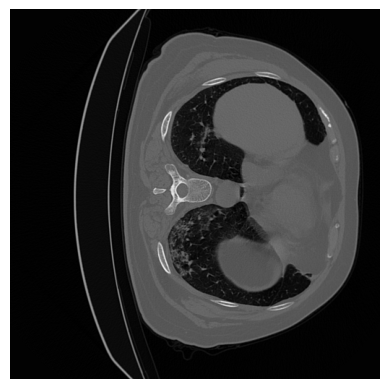

In [28]:
def load_nii_file(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def visualize_slice(scan, slice_index):
    plt.imshow(scan[:, :, slice_index], cmap='gray')
    plt.axis('off')
    plt.show()

ct_scan_path = os.path.join(dataset_path, 'ct_scans/coronacases_org_001.nii')
ct_scan = load_nii_file(ct_scan_path)
visualize_slice(ct_scan, slice_index=100)  # Visualize the 100th slice

# Preprocess the CT scan (normalize the pixel values and resize)


In [29]:
def preprocess_scan(scan, target_size=(128, 128)):
    scan = (scan - np.min(scan)) / (np.max(scan) - np.min(scan))
    resized_slices = [cv2.resize(slice, target_size, interpolation=cv2.INTER_AREA) for slice in scan]
    return np.array(resized_slices)

# Load all CT scans and corresponding masks


In [30]:
def load_data(dataset_path, scan_type='ct_scans', mask_type='infection_mask'):
    scan_paths = sorted(glob(os.path.join(dataset_path, scan_type, '*.nii')))
    mask_paths = sorted(glob(os.path.join(dataset_path, mask_type, '*.nii')))
    scans = []
    masks = []
    for scan_path, mask_path in zip(scan_paths, mask_paths):
        scan = preprocess_scan(load_nii_file(scan_path))
        mask = preprocess_scan(load_nii_file(mask_path))
        if scan.shape == mask.shape:  
            scans.append(scan)
            masks.append(mask)
    return scans, masks

scans, masks = load_data(dataset_path)

scans_2d = np.concatenate([scan for scan in scans], axis=0)
masks_2d = np.concatenate([mask for mask in masks], axis=0)


In [31]:
def validate_shapes(scans, masks):
    min_shape = min([scan.shape[0] for scan in scans])
    scans = [scan[:min_shape] for scan in scans]
    masks = [mask[:min_shape] for mask in masks]
    return np.array(scans), np.array(masks)

scans, masks = validate_shapes(scans, masks)

scans_2d = scans_2d[..., np.newaxis]
masks_2d = masks_2d[..., np.newaxis]


# Split the data into training and testing sets


In [32]:
train_scans, test_scans, train_masks, test_masks = train_test_split(scans_2d, masks_2d, test_size=0.2, random_state=42)

# Simple U-Net model for segmentation


In [33]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,465 (415.88 KB)

 Trainable params: 106,465 (415.88 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model


In [34]:
def train_model(model, train_images, train_masks, epochs=10, batch_size=4):
    model.fit(train_images, train_masks, epochs=epochs, batch_size=batch_size, validation_split=0.1)

train_model(model, train_scans, train_masks, epochs=10, batch_size=4)

Epoch 1/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9823 - loss: 0.0715 - val_accuracy: 0.9889 - val_loss: 0.0249
Epoch 2/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9892 - loss: 0.0239 - val_accuracy: 0.9915 - val_loss: 0.0169
Epoch 3/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9914 - loss: 0.0172 - val_accuracy: 0.9924 - val_loss: 0.0138
Epoch 4/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9921 - loss: 0.0142 - val_accuracy: 0.9927 - val_loss: 0.0126
Epoch 5/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9927 - loss: 0.0127 - val_accuracy: 0.9928 - val_loss: 0.0123
Epoch 6/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9929 - loss: 0.0124 - val_accuracy: 0.9931 - val_loss: 0.0112
Epoch 7/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9934 - loss: 0.0108 - val_accuracy: 0.9932 - val_loss: 0.0114
Epoch 8/10
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9932 - loss: 0

# Evaluate the model on the test set


In [35]:
def evaluate_model(model, test_images, test_masks):
    loss, accuracy = model.evaluate(test_images, test_masks)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

evaluate_model(model, test_scans, test_masks)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9938 - loss: 0.0094
Test Loss: 0.0092617841437459
Test Accuracy: 0.9938488006591797


# Visualize predictions for 5 samples with non-black masks


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


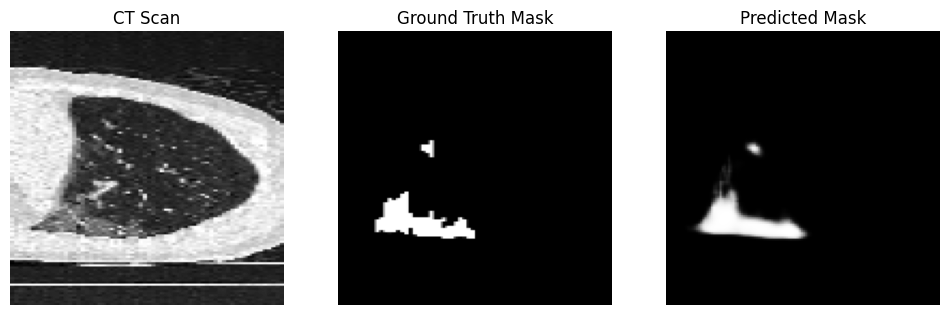

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


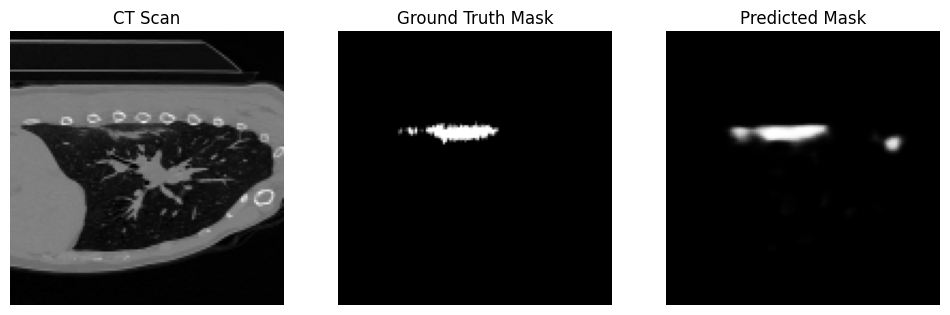

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


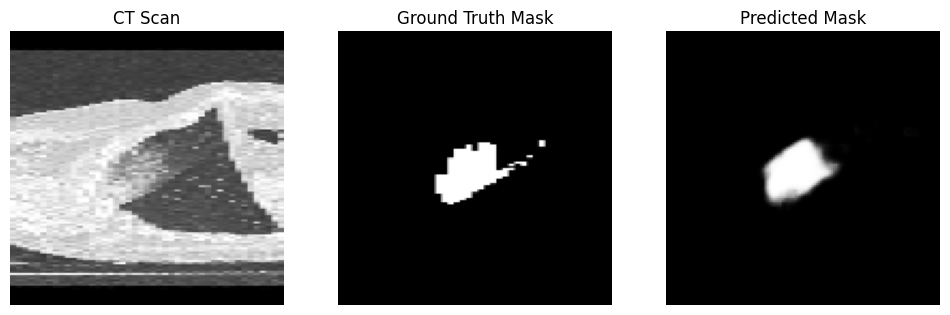

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


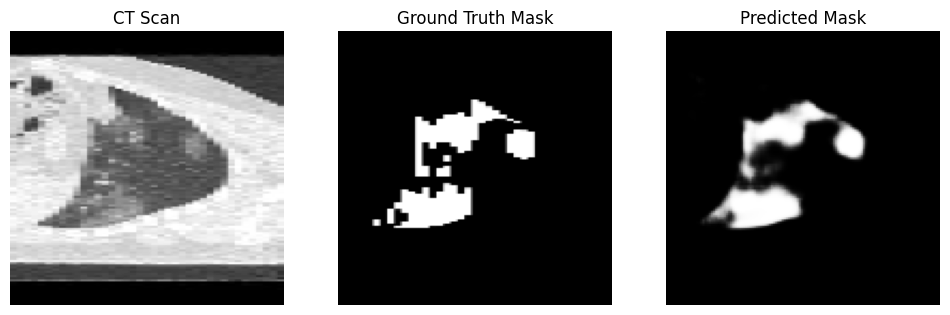

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


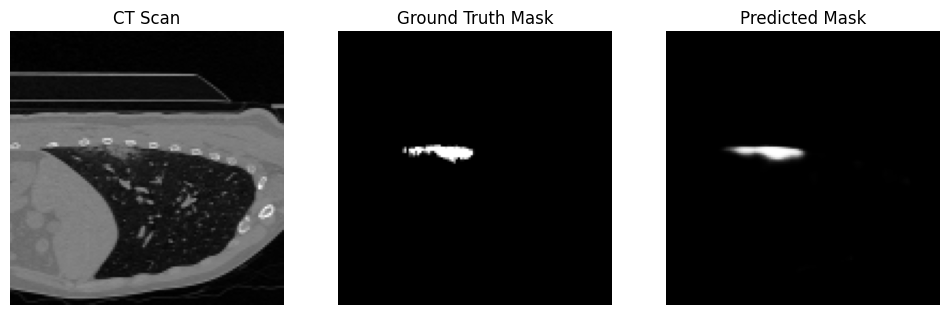

In [36]:
def predict_and_visualize(model, test_image, test_mask):
    prediction = model.predict(test_image[np.newaxis, ...])
    prediction = prediction[0, :, :, 0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('CT Scan')
    plt.imshow(test_image[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(test_mask[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(prediction[:, :], cmap='gray')
    plt.axis('off')

    plt.show()

count = 0
for i in range(len(test_masks)):
    if np.sum(test_masks[i]) > 0:  
        predict_and_visualize(model, test_scans[i], test_masks[i])
        count += 1
    if count == 5:
        break